In [1]:
import sys, os, path
import numpy as np
import torch as th
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')
from scripts.utilities import *

### Interpolation on grid, cutting out boundaries

In [ ]:
train_data_path = '/home/leonriccius/Documents/Fluid_Data/training_data/periodic_hills'
# on workstation: home/leon/Master_Thesis/Fluid_Data ...
rans_time = '1500'

In [ ]:
cases = os.listdir(os.sep.join([train_data_path, 'tensordata']))
print(cases)

In [ ]:
# funcion of the bottom boundary
# characteristic points
x = (1.929/54) * np.array([0., 0.1, 9., 14., 20., 30., 40., 53.9, 54.])
x = np.append(x, 9 - x[::-1])
y = (1.929/54) * np.array([28., 28., 27., 24., 19., 11., 4., 0., 0.])
y = np.append(y, y[::-1])

# spline interpolation
f_bottom = interp1d(x, y, kind='cubic', fill_value='extrapolate')

In [ ]:
# function to create mask for points selection
def mask_boundary_points(x, y, blthickness = 0.15):
    mask = np.ones(x.shape, dtype=bool)
    y_interp = f_bottom(x)
    mask[np.where(y < y_interp + blthickness)] = False
    mask[np.where(y > 3.035 - blthickness)] = False
    mask[np.where(x < 0. + blthickness)] = False
    mask[np.where(x > 9. - blthickness)] = False
    return mask

In [ ]:
# define grid for interpolation
grid_x, grid_y = np.mgrid[0.:9.:150j, 0.:3.05:50j]
grid = th.tensor([grid_x.flatten(), grid_y.flatten()]).T

# get mask for points selection
mask = mask_boundary_points(grid_x.flatten(), grid_y.flatten())

In [ ]:
# loop for rans data
for case in cases:
    # define current path and read in data
    curr_case = os.sep.join([train_data_path, 'rans', case, rans_time])
    rs_rans = th.load(os.sep.join([curr_case, 'RS-torch.th']))
    s = th.load(os.sep.join([curr_case, 'S-torch.th']))
    r = th.load(os.sep.join([curr_case, 'R-torch.th']))
    epsilon0 = th.load(os.sep.join([curr_case, 'epsilon-torch.th']))
    k0 = th.load(os.sep.join([curr_case, 'k-torch.th']))
    grid = th.load(os.sep.join([curr_case, 'grid-torch.th']))[:,0:2]
    
    # expand k
    k = k0.unsqueeze(0).unsqueeze(0).expand(3,3,k0.size()[0])
    k = k.permute(2, 0, 1)
    
    # expand epsilon
    epsilon = epsilon0.unsqueeze(0).unsqueeze(0).expand(3,3,epsilon0.size()[0])
    epsilon = epsilon.permute(2, 0, 1)
    
    # normalize S and R
    s_hat = k/epsilon*s
    r_hat = k/epsilon*r
    
    # compute invariants and basis tensors
    inv = get_invariants(s_hat, r_hat)
    T = get_tensor_functions(s_hat, r_hat)
    
    # compute anisotropy tensor b
    b_rans = rs_rans/(2*k) - 1/3 * th.eye(3).unsqueeze(0).expand(k0.shape[0],3,3)
    
    # interpolate inv, T
    inv_interp = th.tensor(griddata(grid, inv, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)
    T_interp = th.tensor(griddata(grid, T, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)
    b_rans_interp = th.tensor(griddata(grid, b_rans, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)
    grid_interp = th.tensor([grid_x.flatten(), grid_y.flatten()]).T
    
    # remove points close to boundary
    inv_interp = inv_interp[mask]
    T_interp = T_interp[mask]
    grid_interp = grid_interp[mask]
    b_rans_interp = b_rans_interp[mask]
    
    # store inv, T, grid
    storage_path = os.sep.join([train_data_path, 'unscaled_tensordata', case]) # 'tensordata'
#     th.save(inv_interp, os.sep.join([storage_path, 'inv-torch.th']))
#     th.save(T_interp, os.sep.join([storage_path, 'T-torch.th']))y
#     th.save(b_rans_interp, os.sep.join([storage_path, 'b_rans-torch.th']))
#     th.save(grid_interp, os.sep.join([storage_path, 'grid-torch.th']))

In [ ]:
# loop for DNS data
for case in cases:
    # define current path and read in data
    curr_case = os.sep.join([train_data_path, 'dns', case])
    data = np.loadtxt(os.sep.join([curr_case, 'ASCII_Breuer.dat']), skiprows=16)
    
    # get shape of data
    N, M = data.shape
    
    # extract relevant data from dataset
    rs_dns = th.tensor(np.array([data[:,6], data[:,9], np.full(N,0),
                                data[:,9], data[:,7], np.full(N,0),
                                np.full(N,0), np.full(N,0), data[:,8]]).T.reshape(-1,3,3))
    grid = th.tensor([data[:,0],data[:,1]]).T
    k0 = 0.5*th.from_numpy(rs_dns.numpy().trace(axis1 = 1, axis2 = 2))
    
    # expand k
    k = k0.unsqueeze(0).unsqueeze(0).expand(3,3,k0.shape[0])
    k = k.permute(2, 0, 1)

    # compute anisotropy tensor b
    b_dns = rs_dns/(2*k) - 1/3 * th.eye(3).unsqueeze(0).expand(k0.shape[0],3,3)
    
    # interpolate b
    b_dns_interp = th.tensor(griddata(grid, b_dns, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)
    
    # remove points close to boundary
    b_dns_interp = b_dns_interp[mask]
    
    # save b
    storage_path = os.sep.join([train_data_path, 'unscaled_tensordata', case]) # 'tensordata'
#     th.save(b_dns_interp, os.sep.join([storage_path, 'b_dns-torch.th']))

In [ ]:
# grid_x, grid_y = np.mgrid[0.:9.:90j, 0.:3.05:30j]

In [ ]:
mask = mask_boundary_points(grid_x.flatten(), grid_y.flatten())
grid_x_cut, grid_y_cut = (grid_x.flatten()[mask], grid_y.flatten()[mask])

### Interpolate on RANS points, without cutting off boundary regions

In [2]:
# train_data_path = '/home/leonriccius/Documents/Fluid_Data/training_data/periodic_hills'
# # on workstation: home/leon/Master_Thesis/Fluid_Data ...
# rans_time = '1500'

# cases = os.listdir(os.sep.join([train_data_path, 'tensordata_rans_grid']))
# print(cases)

In [3]:
train_data_path = '/home/leonriccius/Documents/Fluid_Data/training_data/conv_div_channel'
# train_data_path = '/home/leonriccius/Documents/Fluid_Data/test_data/curved_backstep'
# on workstation: home/leon/Master_Thesis/Fluid_Data ...
# rans_time = '511'

cases = os.listdir(os.sep.join([train_data_path, 'tensordata_norm_corr_t10']))
cases = [cases[0]]
print(cases)

['12600']


In [ ]:
# train_data_path = '/home/leonriccius/Documents/Fluid_Data/training_data/curved_backstep'
# # on workstation: home/leon/Master_Thesis/Fluid_Data ...
# # rans_time = '511'

# cases = os.listdir(os.sep.join([train_data_path, 'tensordata']))
# cases = [cases[0]]
# print(cases)

In [ ]:
# dir_list = os.listdir(os.sep.join([train_data_path, 'rans', cases[0]]))
# numerics = [entry for entry in dir_list if entry.isnumeric()]
# max([entry for entry in dir_list if entry.isnumeric()])

In [4]:
# loop over flow cases
for case in cases:
    
    # load rans data and compute QoI
    # define current path and read in data
    curr_rans_dir = os.sep.join([train_data_path, 'rans', case])
    rans_time = max([entry for entry in os.listdir(curr_rans_dir) if entry.isnumeric()])
    curr_rans_case = os.sep.join([curr_rans_dir, rans_time])
    
    # load data
    rs_rans = th.load(os.sep.join([curr_rans_case, 'RS-torch.th']))
    s = th.load(os.sep.join([curr_rans_case, 'S-torch.th']))
    r = th.load(os.sep.join([curr_rans_case, 'R-torch.th']))
    epsilon0 = th.load(os.sep.join([curr_rans_case, 'epsilon-torch.th']))
    k0_rans = th.load(os.sep.join([curr_rans_case, 'k-torch.th']))
    grid_rans = th.load(os.sep.join([curr_rans_case, 'grid-torch.th']))[:,0:2]
    
    # expand k
    k_rans = k0_rans.unsqueeze(0).unsqueeze(0).expand(3,3,k0_rans.size()[0])
    k_rans = k_rans.permute(2, 0, 1)
    
    # expand epsilon
    epsilon = epsilon0.unsqueeze(0).unsqueeze(0).expand(3,3,epsilon0.size()[0])
    epsilon = epsilon.permute(2, 0, 1)
    
    # normalize S and R
    s_hat = k_rans/epsilon*s
    r_hat = k_rans/epsilon*r
    
    print('Fluid case: {}'.format(case))
    print('s_hat max value: {:3f}'.format(th.max(th.abs(s_hat))))
    print('r_hat max value: {:3f}'.format(th.max(th.abs(r_hat))))
    
    if th.max(th.abs(s_hat)) > 6. or th.max(th.abs(r_hat)) > 6.:
        print('capping tensors ...')
        s_hat = cap_tensor(s_hat, 6.0)
        r_hat = cap_tensor(r_hat, 6.0)
    
    # compute invariants and basis tensors
    inv = get_invariants(s_hat, r_hat)
    T = get_tensor_functions(s_hat, r_hat)
    
    #enforce 0 trace on tensor basis
    T = enforce_zero_trace(T)
    
    # scale invariants
    inv = mean_std_scaling(inv) # alternative sigmoid_scaling
    
    # compute anisotropy tensor b
    b_rans = rs_rans/(2*k_rans) - 1/3 * th.eye(3).unsqueeze(0).expand(k0_rans.shape[0],3,3)
    
    curr_case = os.sep.join([train_data_path, 'dns', case])
    
#     # for periodic hills
#     data = np.loadtxt(os.sep.join([curr_case, 'ASCII_Breuer.dat']), skiprows=16)
    
#     # load dns data and compute QoI
#     # get shape of data
#     N, M = data.shape

#     # extract relevant data from dataset
#     rs_dns = th.tensor(np.array([data[:,6], data[:,9], np.full(N,0),
#                                 data[:,9], data[:,7], np.full(N,0),
#                                 np.full(N,0), np.full(N,0), data[:,8]]).T.reshape(-1,3,3))
#     grid_dns = th.tensor([data[:,0],data[:,1]]).T
#     k0_dns = 0.5*th.from_numpy(rs_dns.numpy().trace(axis1 = 1, axis2 = 2))

    # for conv div channel
    rs_dns = th.load(os.sep.join([curr_case, 'RS-torch.th']))
    k0_dns = th.load(os.sep.join([curr_case, 'k-torch.th']))
    grid_dns = th.load(os.sep.join([curr_case, 'grid-torch.th'])) # [:,0:2]
    
#     find points with k = 0.0 and remove
#     zero_trace_index = th.nonzero(k0_dns, as_tuple=True)
#     print('removed {} zero trace points'.format(len(k0_dns) - len(zero_trace_index[0])))
#     rs_dns = rs_dns[zero_trace_index]
#     grid_dns = grid_dns[zero_trace_index]
#     k0_dns = k0_dns[zero_trace_index]


    # compute anisotropy tensor b
    b_dns = anisotropy(rs_dns, k0_dns)
    print('check wether b_dns contains nan entries: ', bool(th.max(th.isnan(b_dns))))
    
    print('interpolating ...')
    # interpolare b, rs, and k (might be neede later)
    b_dns_interp = th.tensor(griddata(grid_dns[:,0:2],
                                      b_dns,
                                      (grid_rans[:,0], grid_rans[:,1]),
                                      method='linear'))
    rs_dns_interp = th.tensor(griddata(grid_dns[:,0:2],
                                       rs_dns,
                                       (grid_rans[:,0], grid_rans[:,1]),
                                       method='linear'))
    k0_dns_interp = th.tensor(griddata(grid_dns[:,0:2],
                                       k0_dns,
                                       (grid_rans[:,0], grid_rans[:,1]),
                                       method='linear'))
    print('check wether interpolated b contains nan entries: ', bool(th.max(th.isnan(b_dns_interp))), '\n')
    
    # save all QoI
    test_data_path = '/home/leonriccius/Documents/Fluid_Data/training_data/curved_backstep'
    storage_path = os.sep.join([test_data_path, 'tensordata_norm_corr_t10', case])
#     # save b
#     th.save(b_dns_interp, os.sep.join([storage_path, 'b_dns-torch.th']))
#     th.save(rs_dns_interp, os.sep.join([storage_path, 'rs_dns-torch.th']))
#     th.save(k0_dns_interp, os.sep.join([storage_path, 'k_dns-torch.th']))
    
#     # save inv, T, grid
#     th.save(inv, os.sep.join([storage_path, 'inv-torch.th']))
#     th.save(T, os.sep.join([storage_path, 'T-torch.th']))
#     th.save(b_rans, os.sep.join([storage_path, 'b_rans-torch.th']))
#     th.save(grid_rans, os.sep.join([storage_path, 'grid-torch.th']))

Fluid case: 12600
s_hat max value: 4.127367
r_hat max value: 2.033258
enforcing 0 trace ...
Warning, b contains nan entries. Consider removing nan data points
check wether b_dns contains nan entries:  True
interpolating ...
check wether interpolated b contains nan entries:  True 



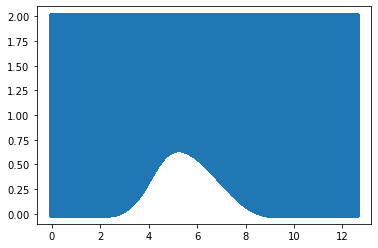

In [6]:
fig, ax = plt.subplots()
ax.scatter(grid_dns[:,0], grid_dns[:,1])

In [ ]:
print(th.max(grid_rans[:,1]), th.max(grid_dns[:,1]))

In [ ]:
index = th.where(b_dns_interp[:,0,0] != b_dns_interp[:,0,0])

In [ ]:
fig, ax = plt.subplots()
ax.scatter(grid_rans[index][:,0], grid_rans[index][:,1], s=0.1)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(grid_dns[:,0], grid_dns[:,1], c=b_dns[:,0,0])

In [ ]:
print(th.max(b_dns[:,1,1]), th.max(b_dns_interp[:,0,0]))

In [ ]:
# fig, ax = plt.subplots(5,1, figsize=(10,15))

# for i in range(5):
# ax[0].scatter(grid_rans[:,0], grid_rans[:,1], c=inv[:,0])
# ax[1].scatter(grid_dns[:,0], grid_dns[:,1], c=b_dns[:,1,1])

In [ ]:
fig, ax = plt.subplots(2,1)
fig1 = ax[0].scatter(grid_rans[:,0], grid_rans[:,1], c=b_dns_interp[:,0,0])
fig2 = ax[1].scatter(grid_rans[:,0], grid_rans[:,1], c=b_dns_interp[:,1,1])
fig.colorbar(fig1, ax=ax[0])
fig.colorbar(fig2, ax=ax[1])

In [ ]:
# index = th.isnan(b_dns_interp[:,0,0])
# nan_cells = grid_rans[index]

In [ ]:
# index_nonzero = th.nonzero(k0_dns==0.0, as_tuple=True)
# nonzero_cells = grid_dns[index_nonzero]
# nonzero_b = b_dns[index_nonzero]

In [ ]:
# bool(th.max(th.isnan(nonzero_b[:,0,0])))

In [ ]:
# len(index_nonzero[0])

In [ ]:
fig, ax = plt.subplots()
ax.scatter(nonzero_cells[:,0], nonzero_cells[:,1])

In [ ]:
index = th.isnan(b_dns[:,0,0])
nan_cells = grid_dns[index]

In [ ]:
fig, ax = plt.subplots()
ax.scatter(nan_cells[:,0], nan_cells[:,1])

In [ ]:
type(grid_rans)

In [ ]:
grid_dns.shape

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(grid_dns[:,0], grid_dns[:,1], c=b_dns[:,0,0], s=2.)
# ax.scatter(grid_rans[:,0], grid_rans[:,1], c=b_dns)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(grid_rans[:,0], grid_rans[:,1], c=b_dns_interp[:,0,0])

In [ ]:
print(b_dns_interp[:,0,0])

In [ ]:
# case = cases[0]

# curr_case = os.sep.join([train_data_path, 'rans', case, rans_time])
# rs_rans = th.load(os.sep.join([curr_case, 'RS-torch.th']))
# s = th.load(os.sep.join([curr_case, 'S-torch.th']))
# r = th.load(os.sep.join([curr_case, 'R-torch.th']))
# epsilon0 = th.load(os.sep.join([curr_case, 'epsilon-torch.th']))
# k0 = th.load(os.sep.join([curr_case, 'k-torch.th']))
# grid = th.load(os.sep.join([curr_case, 'grid-torch.th']))[:,0:2]

In [ ]:
# # loop for DNS data
# for case in cases:
#     curr_case = os.sep.join([train_data_path, 'dns', case])
#     data = np.loadtxt(os.sep.join([curr_case, 'ASCII_Breuer.dat']), skiprows=16)

#     # get shape of data
#     N, M = data.shape

#     # extract relevant data from dataset
#     rs_dns = th.tensor(np.array([data[:,6], data[:,9], np.full(N,0),
#                                 data[:,9], data[:,7], np.full(N,0),
#                                 np.full(N,0), np.full(N,0), data[:,8]]).T.reshape(-1,3,3))
#     grid_dns = th.tensor([data[:,0],data[:,1]]).T
#     k0 = 0.5*th.from_numpy(rs_dns.numpy().trace(axis1 = 1, axis2 = 2))

#     # expand k
#     k = k0.unsqueeze(0).unsqueeze(0).expand(3,3,k0.shape[0])
#     k = k.permute(2, 0, 1)

#     # compute anisotropy tensor b
#     b_dns = rs_dns/(2*k) - 1/3 * th.eye(3).unsqueeze(0).expand(k0.shape[0],3,3)

#     # interpolare b
#     b_dns_interp = th.tensor(griddata(grid_dns, b_dns, (grid[:,0], grid[:,1]), method='linear'))
    
#     # save b
#     storage_path = os.sep.join([train_data_path, 'unscaled_tensordata', case]) # 'tensordata'
# #    th.save(b_dns_interp, os.sep.join([storage_path, 'b_dns-torch.th']))

In [ ]:
fig, ax = plt.subplots(figsize=(18,5))

ax.scatter(grid_x, grid_y, s=10)
ax.scatter(grid_x_cut, grid_y_cut,s=3)

In [ ]:
grid_all_x, grid_all_y = np.mgrid[0.:9.:300j, 0.:3.035:100j]
grid_all_z1 = griddata(grid_interp, T_interp[:,4,1,1], (grid_all_x, grid_all_y), method='linear') # inv[:,1]

fig, ax = plt.subplots(figsize=(20,5))
DNS_all_domain = ax.contourf(grid_all_x, grid_all_y, grid_all_z1)
fig.colorbar(DNS_all_domain, ax=ax)